Обучите 3 разные baseline-модели на полученных наборах данных и оцените их качество. На прошлой неделе вы выбрали методику оценки качества моделей на основе кросс-валидации, а также основную и вспомогательные метрики. Оцените с их помощью получившуюся модель. Обратите внимание, что под разными моделями понимаются именно разные алгоритмы классификации. Например, 2 модели, реализующие метод k ближайших соседей с разными k, будут считаться одним baseline-решением (хотя и с разными параметрами). Напоминаем, что отложенная выборка (hold-out dataset) не должна использоваться для построения и оценки baseline-моделей!

In [2]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# считываем ту часть данных, что оставили для работы в прошлый раз.
df = pd.read_csv('short_data.csv')
df.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229,churn
0,3052.000000,6.792126,1244.979978,480.000000,600.000000,20.000000,480.000000,200.000000,0.000000,8.275200e+04,...,hLKtJ9p,Al6ZaUT,vr93T2a,LM8l689qOp,no_value,fKCe,02N6s8f,xwM2aC7IdeMC0,no_value,-1
1,1953.000000,7.000000,448.000000,176.000000,220.000000,0.000000,72.000000,311.760000,0.000000,4.698780e+06,...,4UxGlow,zCkv,catzS2D,LM8l689qOp,no_value,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,-1
2,1533.000000,7.000000,4.000000,332.000000,415.000000,0.000000,144.000000,220.080000,5.000000,8.643840e+05,...,ylCK5YS,oslk,e4lqvY0,LM8l689qOp,no_value,xb3V,RAYp,F2FyR07IdsN7I,no_value,1
3,1319.915394,6.792126,1244.979978,233.876227,289.220209,4.508601,96.228101,224.303641,0.710038,2.574737e+06,...,ClzupgV,d0EEeJi,6Uh67Lk,LM8l689qOp,no_value,453m,02N6s8f,F2FyR07IdsN7I,no_value,-1
4,889.000000,0.000000,0.000000,200.000000,250.000000,2.000000,48.000000,320.400000,0.000000,6.830160e+06,...,0MQv48t,oslk,d0BOtEt,LM8l689qOp,no_value,3Cy4,RAYp,F2FyR07IdsN7I,no_value,-1


In [4]:
# Отделяем метки
labels = df['churn']
df = df.drop('churn', axis=1)
labels = pd.Series(np.where(labels == -1, 0, 1))

In [5]:
# Отмасштабируем числовые признаки
real = df.loc[:, :'Var189']
real = pd.DataFrame(StandardScaler().fit_transform(real), columns=real.columns)

C:\Code\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Code\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [6]:
# Добавим квадраты признаков
real_sqr = real ** 2
real_sqr.columns = real.columns+'_sqr'

In [7]:
def cat_unique(cat):
    plt.figure(figsize=(20, 5))
    sns.barplot(x='index', y=0, data=cat.apply(lambda x: np.unique(x).shape[0], axis=0).reset_index())
    plt.title('Количество уникальных категорий у категориальных признаков')
    plt.ylabel('Количество')
    plt.xlabel('Признак')
    plt.xticks(rotation=90);

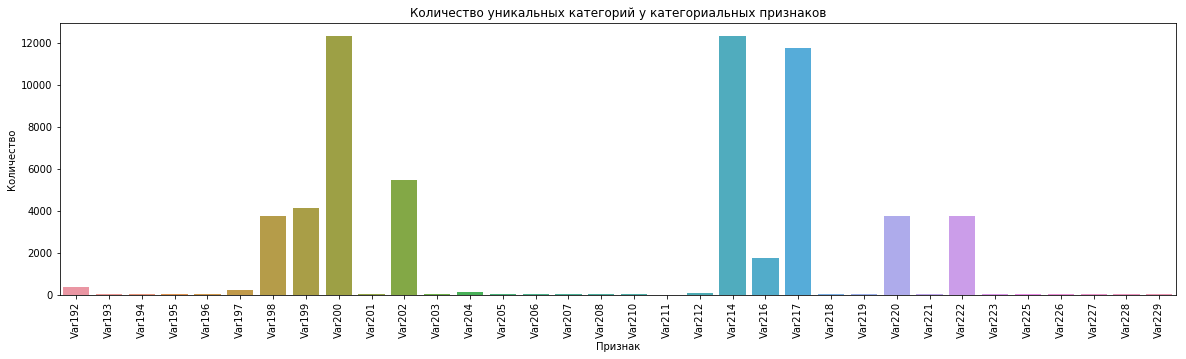

In [8]:
# Посмотрим на распределение категориальных
cat = df.loc[:, 'Var192':]

cat_unique(cat)

Видим, что есть признаки с тысячами значений. В таком случае преобразованные данные будут занимать слишком много места.
Оставим только часто повторяющиеся, остальные объединим.

In [9]:
def change_labels(column):
    val = column.value_counts()
    
    new_val = (val >= 500) * range(1, len(val) + 1) if len(val) > 50 else (val >= 0) * range(1, len(val) + 1)
    new_my_col = column.map(new_val)
    return new_my_col

new_cat = cat.apply(lambda x: change_labels(x), axis=0)

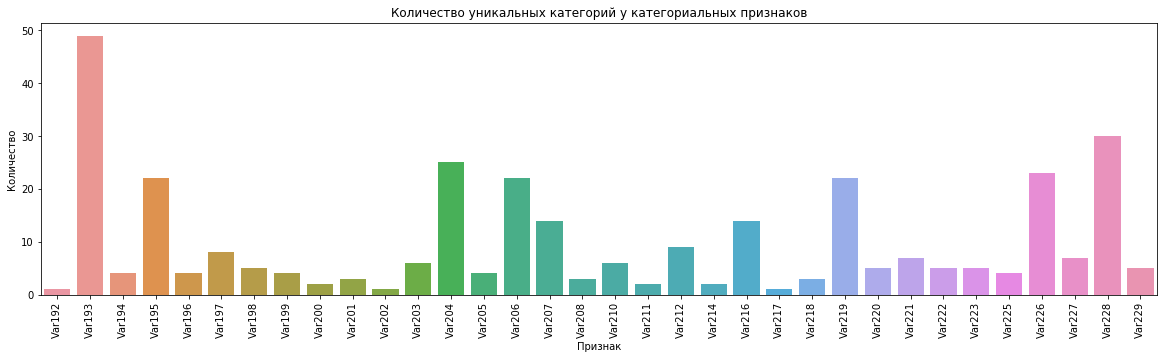

In [10]:
# Посмотрим на новое распределение категориальных 
plt.figure(figsize=(20, 5))
sns.barplot(x='index', y=0, data=new_cat.apply(lambda x: np.unique(x).shape[0], axis=0).reset_index())
plt.title('Количество уникальных категорий у категориальных признаков')
plt.ylabel('Количество')
plt.xlabel('Признак')
plt.xticks(rotation=90);

Так-то лучше. Будем надеяться, что мы не потеряли много информации. Применим Dummy кодирование

In [11]:
dummy_data = pd.concat((real, 
                        real_sqr, 
                        pd.get_dummies(new_cat, columns=new_cat.columns ,drop_first=True)), axis=1)

In [12]:
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Columns: 379 entries, Var6 to Var229_5
dtypes: float64(86), uint8(293)
memory usage: 33.7 MB


Удалим малозначимые признаки, для этого используем ансамбль деревьев.

In [13]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier

In [14]:
etc = ExtraTreesClassifier(n_estimators=20)
etc.fit(dummy_data, labels)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

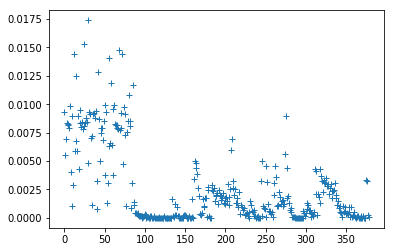

In [15]:
plt.plot(etc.feature_importances_, '+')

Большинство признаков имеют значимость около нуля. Удалим их, это позволит модели не обучаться на шумовых данных.

In [16]:
clear_data = dummy_data.drop(dummy_data.columns[etc.feature_importances_ < 0.001], axis=1)

etc.fit(clear_data, labels)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

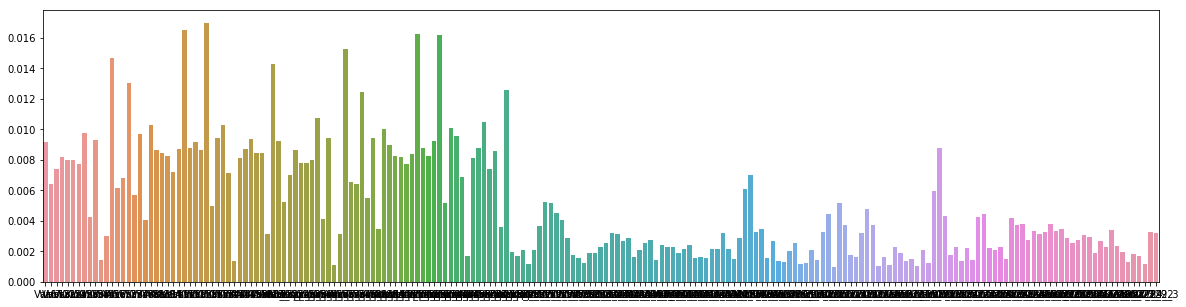

In [17]:
plt.figure(figsize=(20, 5))
sns.barplot(x=clear_data.columns.values, y=etc.feature_importances_)

Теперь вроде бы остались только более-менее значимые признаки, значит будем строить бейзлайн модели.

In [18]:
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB

In [19]:
def cv_scoring(estimators, data=clear_data, cv=3):
    scorers = ['roc_auc', 'f1', 'accuracy', 'recall']
    cv_df = pd.DataFrame(columns=['estimator', 'roc_auc', 'f1', 'accuracy', 'recall'])
    
    for estimator in estimators:
        scores = cross_validate(estimator, data, labels, scoring=['roc_auc', 'f1', 'accuracy', 'recall'], cv=cv)
        voc = {'estimator': str(estimator).split('(')[0],
               'roc_auc': scores['test_roc_auc'].mean(), 
               'f1': scores['test_f1'].mean(), 
               'accuracy': scores['test_accuracy'].mean(), 
               'recall': scores['test_recall'].mean()} # Делаем словарь, чтобы потом его добавить в датафрейм
    
        cv_df = cv_df.append(voc, ignore_index=True)
        
    return cv_df

Обучим 3 модели: RidgeClassifier, GradientBoostingClassifier и наивного байеса.

In [20]:
estimators = [RidgeClassifier(), GradientBoostingClassifier(n_estimators=20), GaussianNB()]

cv_df = cv_scoring(estimators)
cv_df

,estimator,roc_auc,f1,accuracy,recall
0,RidgeClassifier,0.699493,0.002963,0.925333,0.001491
1,GradientBoostingClassifier,0.729322,0.006650,0.925611,0.003356
2,GaussianNB,0.617158,0.150871,0.277472,0.859806


Результат не впечатляет. В основном у всех моделей маленький Recall, кроме наивного байеса, у которого маленькая точность. Лучший результат, конечно, показал градиентный бустинг.